In [1]:
import tensorflow as tf

In [2]:
data = tf.keras.utils.get_file('cats.and_dog.zip',
                             'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
                              extract=True
                            )

68616192/68606236 [==============================] - 2s 0us/step


In [3]:
data

'/root/.keras/datasets/cats.and_dog.zip'

In [4]:
import os

In [5]:
os.listdir('/root/.keras/datasets/cats_and_dogs_filtered')

['train', 'validation', 'vectorize.py']

In [6]:
import pathlib

In [7]:
path = pathlib.Path('/root/.keras/datasets/cats_and_dogs_filtered')

In [8]:
path

PosixPath('/root/.keras/datasets/cats_and_dogs_filtered')

In [9]:
d = path.glob('train/*/*.jpg')

In [ ]:
list(d)

In [ ]:
from PIL import Image

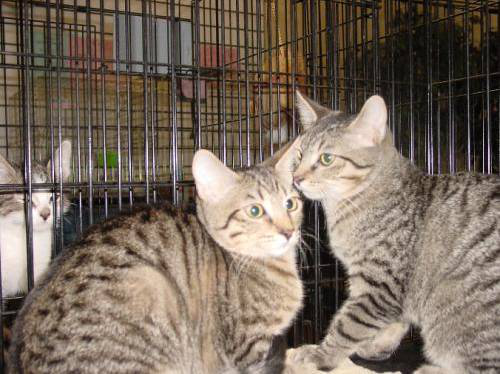

In [ ]:
Image.open(next(d))

In [ ]:
dogs = path.glob('train/dogs/*.jpg')

In [ ]:
len(list(dogs))

1000

In [ ]:
cats = path.glob('train/cats/*.jpg')

In [ ]:
len(list(cats))

1000

In [ ]:
# cats : 1000
# dogs : 1000
# balanced datasets

In [10]:
data = tf.keras.preprocessing.image_dataset_from_directory(path, image_size=(224,224))

Found 3000 files belonging to 2 classes.


In [11]:
train = pathlib.Path('/root/.keras/datasets/cats_and_dogs_filtered/train')
validation = pathlib.Path('/root/.keras/datasets/cats_and_dogs_filtered/validation')

In [12]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train, batch_size=64, image_size=(224, 224))
validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation, image_size=(224, 224))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 모바일 서비스(= 성능감소)
1. 기존 똑같이
2. 전이 학습

In [13]:
m1 = tf.keras.applications.MobileNet()

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
tf.keras.utils.plot_model(m1)

In [16]:
m2 = tf.keras.applications.MobileNetV2()

14548992/14536120 [==============================] - 1s 0us/step


In [ ]:
tf.keras.utils.plot_model(m2)

## Finetuning
- Feature Extraction
- Fine Tuning
 - weigh Freezing 
 - weigh unfreezing

In [ ]:
# base_mode1 = backbone 의 학습 환경과 똑같은 전처리 기법 사용 해야 됨
# tf.keras.applications.mobilenet_v2.preprocess_input

In [62]:
mobile = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))

In [63]:
# mobile.summary() # 7 x 7 Yulo

## target /source (dog vs cat)
### 1000 정도 분류 할 수 있다면 세상 거의 모든건 분류 할 수 있다
## data size ( size 가 크면 많이 바꿀 수 있다)
### 2000 / 1000

## Flatten / GAP

In [64]:
len(mobile.layers)

154

In [65]:
import inspect

In [66]:
print(inspect.getsource(tf.keras.applications.mobilenet_v2.preprocess_input))

@keras_export('keras.applications.mobilenet_v2.preprocess_input')
def preprocess_input(x, data_format=None):
  return imagenet_utils.preprocess_input(x, data_format=data_format, mode='tf')



In [67]:
mobile.trainable = True
for i in mobile.layers[:100]:
  i.trainable = False

In [68]:
input_ = tf.keras.Input((224, 224, 3))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset=-1)(input_) # -1 < x < 1로 정규화 tf.keras.applications.mobilenet_v2.preprocess_input 해줌
x = tf.keras.applications.mobilenet_v2.preprocess_input(input_) # 핵심!!!! # base_mode1 = backbone 의 학습 환경과 똑같은 전처리 기법 사용 해야 됨
x = mobile(input_, training=True) # Batch N 있고 학습 시키기 때문에 training=True
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1)(x)

In [69]:
model = tf.keras.Model(input_, x)

In [70]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(0.001), # FT 핵심
              metrics=['acc'])

In [71]:
history = model.fit(train_data, validation_data = validation_data, epochs=10,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/10
32/32 [==============================] - 11s 206ms/step - loss: 0.7027 - acc: 0.6925 - val_loss: 0.5043 - val_acc: 0.7330
Epoch 2/10
32/32 [==============================] - 6s 183ms/step - loss: 0.2917 - acc: 0.8600 - val_loss: 0.5526 - val_acc: 0.7920
Epoch 3/10
32/32 [==============================] - 6s 183ms/step - loss: 0.1915 - acc: 0.9200 - val_loss: 0.5330 - val_acc: 0.8180


In [29]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


# Feature Extraction
- 기존의 지식은 내 전용으로 모델 만들 때 학습 시키지 않고 그대로 사용

In [ ]:
vgg = tf.keras.applications.VGG16(include_top=False) # convolution 만 가져옴 

In [ ]:
vgg.trainable = False # freezing # Non-trainable params: 14,714,688 ==> 학습 시키지 않고 그대로 사용 : Feature Extraction`
# vgg.trainable = True # unfreezing : Fine Tuning

In [ ]:
1000개 분류용
- FE : 개 / 고양이 분류 능력 확보 : FC >
- FT : 개 / 고양이 분류 능력 확보 but 조금 부족함 > 내 도메인에 맞쳐서 조금 미세하게 학습한 웨이트 수정하자!!

In [ ]:
개 능력 확보
- FE : 고양이 분류 능력 가능
- FT : 고양이 분류 능력 가능 but 조금 부족함 > 고양이 데이터 가지고 미세하게 (low learning rate) > catastrophic forgetting 때문에

In [ ]:
for i in vgg.layers:
  print(i.name)

input_11
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
# importance
# vgg.trainable = False 와 동일
for i in vgg.layers[:]: # mutable
# for i in vgg.layers[5:]: # mutable
  i.trainable = False

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
input_ = tf.keras.Input((224,224,3))

In [ ]:
x = vgg(input_, training=True) # dropout, Batch N 안하면 traing=True 생략가능

In [ ]:
# 1차원으로 만들기 위한 2가지 방법
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

In [ ]:
model = tf.keras.Model(input_, x)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
__________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['acc'])

In [ ]:
history = model.fit(train_data, validation_data = validation_data, epochs=10)

Epoch 1/10
32/32 [==============================] - 18s 522ms/step - loss: 0.6774 - acc: 0.8625 - val_loss: 0.2251 - val_acc: 0.9370
Epoch 2/10
32/32 [==============================] - 18s 533ms/step - loss: 0.1502 - acc: 0.9525 - val_loss: 0.6312 - val_acc: 0.8650
Epoch 3/10
32/32 [==============================] - 17s 526ms/step - loss: 0.1109 - acc: 0.9610 - val_loss: 0.1266 - val_acc: 0.9590
Epoch 4/10
32/32 [==============================] - 17s 519ms/step - loss: 0.0887 - acc: 0.9700 - val_loss: 0.4124 - val_acc: 0.9060
Epoch 5/10
32/32 [==============================] - 17s 518ms/step - loss: 0.0547 - acc: 0.9795 - val_loss: 0.1066 - val_acc: 0.9650
Epoch 6/10
32/32 [==============================] - 17s 516ms/step - loss: 0.0186 - acc: 0.9925 - val_loss: 0.1208 - val_acc: 0.9700
Epoch 7/10
32/32 [==============================] - 17s 527ms/step - loss: 0.0272 - acc: 0.9900 - val_loss: 0.1557 - val_acc: 0.9620
Epoch 8/10
32/32 [==============================] - 17s 523ms/step - 

In [ ]:
resnet = tf.keras.applications.ResNet50(include_top=False) # convolution 만 가져옴  : Feature Extraction

In [ ]:
resnet.trainable = False # Non-trainable params: 23,587,712 ==> 학습 시키지 않고 그대로 사용

In [ ]:
resnet.summary()

In [ ]:
# !pip install -U model-profiler

In [ ]:
import model_profiler

In [ ]:
print(model_profiler.model_profiler(vgg, 128)) # 필용한 HW 사양

| Model Profile                    | Value    | Unit    |
|----------------------------------|----------|---------|
| Selected GPUs                    | ['0']    | GPU IDs |
| No. of FLOPs                     | 0.3093   | BFLOPs  |
| GPU Memory Requirement           | 7.4067   | GB      |
| Model Parameters                 | 138.3575 | Million |
| Memory Required by Model Weights | 527.7921 | MB      |


/usr/local/lib/python3.7/dist-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),


In [ ]:
print(model_profiler.model_profiler(resnet, 128)) # 필용한 HW 사양

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0771  | BFLOPs  |
| GPU Memory Requirement           | 17.7242 | GB      |
| Model Parameters                 | 25.6367 | Million |
| Memory Required by Model Weights | 97.7963 | MB      |


/usr/local/lib/python3.7/dist-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),


## transfer learning
- deep learning : feature representation transfer
                  - feature extraction
                  - fine tuning

In [ ]:
# Functional Model
training = True # default - 생략가능
# transfer learning
1. freeze (no update) > training = False
2. fine tuning (update) > training = True 혹은 생략